## Tuneo de hiperparámetros

El objetivo de este notebook es buscar el mejor conjunto de hiperparámetros para el modelo seleccionado.

### Import de los paquetes

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from optuna.visualization import plot_optimization_history
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split

### Configuraciones

In [2]:
# Variable para setear semilla
SEED = 0

In [3]:
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [4]:
pd.set_option("display.max_columns", None)

### Funciones auxiliares

#### Graficos

In [5]:
def plot_confusion_matrix(cm: np.ndarray, classes: list, ax=None):
    """
    Grafica una matriz de confusión.

    Args:
        cm (np.ndarray): La matriz de confusión.
        classes (list): Las etiquetas de clase.
        ax: El objeto de eje para dibujar el gráfico (por defecto: None).

    Returns:
        None
    """
    if ax is None:
        ax = plt.gca()  # Obtener el eje actual si no se proporciona uno

    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.set_title("Matriz de Confusión")
    plt.colorbar(im, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = ".2f"
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        ax.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    ax.set_ylabel("Etiqueta Real")
    ax.set_xlabel("Etiqueta Predicha")

In [6]:
def plot_roc_curve(y_test: np.ndarray, y_proba: np.ndarray, ax=None):
    """
    Grafica la curva ROC.

    Args:
        y_test (np.ndarray): Las etiquetas reales.
        y_proba (np.ndarray): Las probabilidades predichas.
        ax: El objeto de eje para dibujar el gráfico (por defecto: None).

    Returns:
        None
    """
    if ax is None:
        ax = plt.gca()  # Obtiene el eje actual si no se proporciona uno

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    ax.plot(fpr, tpr, label="Curva ROC (AUC = %0.2f)" % roc_auc)
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("Tasa de Falsos Positivos")
    ax.set_ylabel("Tasa de Verdaderos Positivos")
    ax.set_title("Curva ROC")
    ax.legend(loc="lower right")

#### Generación de métricas

In [7]:
def track_metrics(
    pipeline,
    x: np.ndarray,
    y: np.ndarray,
    set_name: str = "test",
    threshold: float = 0.5,
):
    """
    Registra métricas para un pipeline de clasificación.

    Args:
        pipeline: El pipeline de clasificación.
        x (np.ndarray): Las características de entrada.
        y (np.ndarray): Las etiquetas reales.
        set_name (str): El nombre del conjunto de datos (por defecto: "test").
        threshold (float): El umbral de predicción (por defecto: 0.5).

    Returns:
        None
    """
    # Predecir probabilidades
    y_proba = pipeline.predict_proba(x)[:, 1]

    # Aplicar el umbral
    y_pred = (y_proba >= threshold).astype(int)

    # Calcular la precisión
    accuracy = accuracy_score(y, y_pred)

    # Calcular métricas
    cm = confusion_matrix(y, y_pred)

    # Imprimir el informe de clasificación
    report = classification_report(y, y_pred, target_names=["Negativo", "Positivo"])
    print(f"Informe de Clasificación:\n{report}")

    # Calcular precision, recall, f1-score y support para cada clase utilizando output_dict
    metrics_dict = precision_recall_fscore_support(
        y, y_pred, average=None, labels=[0, 1]
    )

    # Crear una figura con dos subgráficos en la misma fila
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))

    # Graficar la matriz de confusión en el primer subgráfico
    plot_confusion_matrix(cm, classes=["Negativo", "Positivo"], ax=axes[0])
    axes[0].set_title("Matriz de Confusión")

    # Graficar la curva ROC en el segundo subgráfico
    plot_roc_curve(y, y_proba, ax=axes[1])
    axes[1].set_title("Curva ROC")
    plt.show()

    # Devolver métricas como un diccionario
    metrics = {
        f"{set_name}_Precisión (Negativo)": round(metrics_dict[0][0], 2),
        f"{set_name}_Precisión (Positivo)": round(metrics_dict[0][1], 2),
        f"{set_name}_Recall (Negativo)": round(metrics_dict[1][0], 2),
        f"{set_name}_Recall (Positivo)": round(metrics_dict[1][1], 2),
        f"{set_name}_F1-Score (Negativo)": round(metrics_dict[2][0], 2),
        f"{set_name}_F1-Score (Positivo)": round(metrics_dict[2][1], 2),
        f"{set_name}_Exactitud": round(accuracy, 2),
    }

    return metrics

### Carga de datos

In [8]:
df = pd.read_csv("../data/processed/dataset_training_v0.csv")
df.shape

(2962, 18)

In [9]:
df.head()

,invoiceId,businessId,payerId,relationDays,relationRecurrence,issuerCancelledInvoices,diasActividadPagador,facturaMorosa,montoFacturaWsz,issuerInvoicesAmountWsz,Clients12MonthsWsz,payerAmountFacturas,payerRatioMorosidad,payerAvgAmountFacturas,payerAvgDiasMora,payerDesvAmount,businessRatioMororsidad,businessAvgDiasMora
0,11654,5,5015,428.0,10.166667,0.021942,2632.0,1,4713103.0,187036960.0,4.0,181609529.0,0.400000,4035767,2.266667,677336.0,0.000000,0.000000
1,13430,5,5015,455.0,9.891304,0.020079,2659.0,0,7879645.0,231623853.0,4.0,210861531.0,0.423077,4055029,2.865385,3824616.0,1.000000,18.000000
2,15957,5,5015,493.0,9.264151,0.016629,2697.0,1,1190417.0,272695026.0,4.0,261505599.0,0.348485,3962206,6.348485,-2771789.0,0.500000,6.000000
3,18135,5,5015,542.0,9.016667,0.014322,2746.0,0,189924.0,321318559.0,3.0,278112178.0,0.375000,3862669,7.041667,-3672745.0,0.666667,4.333333
4,19438,5,5015,562.0,8.920635,0.013314,2766.0,0,3755846.0,346234215.0,3.0,297456818.0,0.376623,3863075,6.181818,-107229.0,0.500000,3.250000


### Split del conjunto de entrenamiento

La estrategia utilizada para evaluar el modelo es separar los datos en train, test y validación:
- El conjunto de **train** será el **80%** de los datos con los que contamos y será utilizado para entrenar el modelo.
- El conjunto de **test**, será utilizado para evaluar la performance del modelo. Representará un **10%** de los datos y será seleccionado aleatoriamente.
- Por último, el conjunto de **validación**, que será utilizado para el tuneo de los hiperparámetros, representará aproximadamente el **10%** de los datos. Dado que este conjunto no tiene que ser visto por el modelo desde ningún lugar, seleccionaremos las últimas facturas emitidas como emulando la utilización del modelo.

In [10]:
# Ordenamos los datos
df = df.sort_values("invoiceId").copy()
df.drop(columns=["invoiceId", "businessId", "payerId"], inplace=True)

# Especificar las características (X) y el objetivo (y)
x = df.drop(columns=["facturaMorosa"], axis=1)
y = df["facturaMorosa"]

# Obtener las últimas 150 filas para validación
x_val = x.iloc[-250:]
y_val = y.iloc[-250:]

# Eliminar las últimas 150 filas de x e y
x = x.iloc[:-250]
y = y.iloc[:-250]

# Dividir el conjunto en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=SEED
)


# Verificamos las formas de los conjuntos resultantes
print("Formas de los conjuntos:")
print("Entrenamiento:", x_train.shape, y_train.shape)
print("Prueba:", x_test.shape, y_test.shape)
print("Validación:", x_val.shape, y_val.shape)


# Mostrar las formas de las particiones
print("Forma de x_train:", x_train.shape)
print("Forma de x_val:", x_val.shape)
print("Forma de x_test:", x_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de y_test:", y_test.shape)

Formas de los conjuntos:
Entrenamiento: (2440, 14) (2440,)
Prueba: (272, 14) (272,)
Validación: (250, 14) (250,)
Forma de x_train: (2440, 14)
Forma de x_val: (250, 14)
Forma de x_test: (272, 14)
Forma de y_train: (2440,)
Forma de y_val: (250,)
Forma de y_test: (272,)


### Tuning

#### Definimos la funcion objetivos y corremos diferentes trials

In [11]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 6, 100),
        "min_samples_split": trial.suggest_float("min_samples_split", 0.1, 1.0),
        "min_samples_leaf": trial.suggest_float("min_samples_leaf", 0.1, 0.5),
        "max_features": trial.suggest_float("max_features", 0.1, 1.0),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    }

    model = RandomForestClassifier(**params)
    model.fit(x_train, y_train)

    y_pred_prob = model.predict_proba(x_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_prob)

    return auc_score


study = optuna.create_study(
    direction="maximize"
)  # 'maximize' si estamos buscando maximizar el AUC-ROC
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Obtener los mejores hiperparámetros encontrados
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

  0%|          | 0/100 [00:00<?, ?it/s]

Mejores hiperparámetros: {'n_estimators': 211, 'max_depth': 70, 'min_samples_split': 0.11391573663562704, 'min_samples_leaf': 0.1015248385855935, 'max_features': 0.505236972643752, 'bootstrap': False}


#### Visualización de los trials

In [12]:
plot_optimization_history(study)

#### Entrenamiento

Entrenamos el modelo con los mejores hiperparámetros seleccionados y validamos que no hayamos caido en overfitting.

In [13]:
# Entrenamos el modelo con los mejores hiperparámetros
best_model = RandomForestClassifier(**best_params)
best_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=70,
                       max_features=0.505236972643752,
                       min_samples_leaf=0.1015248385855935,
                       min_samples_split=0.11391573663562704, n_estimators=211)

#### Resultados

##### Evaluamos en el conjunto de test

Informe de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.73      0.81      0.77       166
    Positivo       0.64      0.52      0.57       106

    accuracy                           0.70       272
   macro avg       0.68      0.67      0.67       272
weighted avg       0.69      0.70      0.69       272



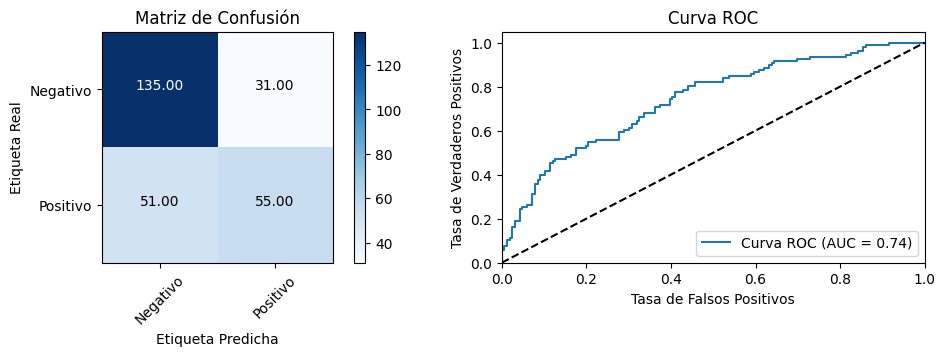

In [14]:
_ = track_metrics(
    best_model,
    x_test,
    y_test,
    set_name="test",
    threshold=0.5,
)

##### Evaluamos en el conjunto de validación

Informe de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.77      0.84      0.81       177
    Positivo       0.51      0.40      0.45        73

    accuracy                           0.71       250
   macro avg       0.64      0.62      0.63       250
weighted avg       0.70      0.71      0.70       250



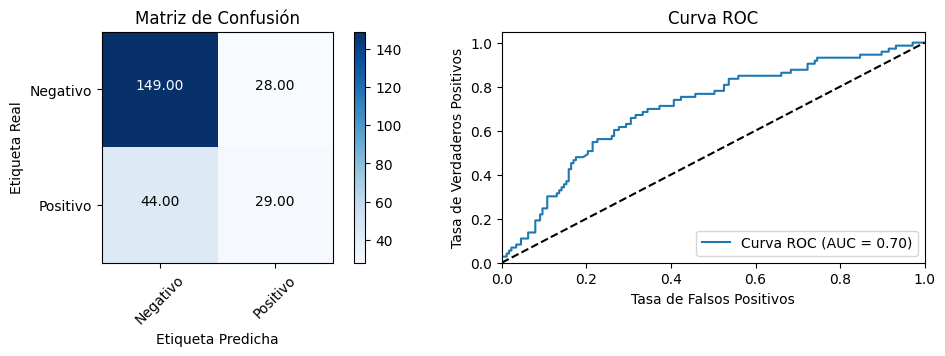

In [15]:
_ = track_metrics(
    best_model,
    x_val,
    y_val,
    set_name="val",
    threshold=0.5,
)